In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ranksums

import glob
import os
import matplotlib.pyplot as plt

from modules.utilities import *
from modules.constants import *
from modules import CliffsDelta
from scipy.stats import shapiro

plt.rcParams.update(mpl_params)

TOPIC_DIR = "./Outputs/BERTopic/Topics"
DATA_DIR = "./Outputs/PerformancePRs"

In [2]:
commit_df = read_aidev(FileName.POP_PR_COMMIT_DETAILS)
commit_df

,sha,pr_id,author,committer,message,commit_stats_total,commit_stats_additions,commit_stats_deletions,filename,status,additions,deletions,changes,patch
0,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,.github/workflows/compile-llms-txt.yml,added,38.0,0.0,38.0,"@@ -0,0 +1,38 @@\n+name: Compile llms.txt\n+\n..."
1,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,docs/compile_llms_txt.py,added,47.0,0.0,47.0,"@@ -0,0 +1,47 @@\n+import os\n+from pathlib im..."
2,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,llms.txt,added,22923.0,0.0,22923.0,None
3,dbd1b5f129f7cffa5ce284d7255814c98bcc38a2,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Fix lint issues: remove unused variable and ap...,35,18,17,docs/compile_llms_txt.py,modified,18.0,17.0,35.0,"@@ -1,47 +1,48 @@\n import os\n from pathlib i..."
4,c2659cfdedf666c8f14753d71664563c2a932b23,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Update llms.txt to follow official standard wi...,23035,89,22946,docs/compile_llms_txt.py,modified,51.0,36.0,87.0,"@@ -3,45 +3,60 @@\n \n \n def compile_llms_txt..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711918,b779b9b95559531dd5eb8a213815489d2b600ffa,3246680171,max-sixty,max-sixty,Add CLAUDE.md for development guidelines\n\nTh...,53,53,0,CLAUDE.md,added,53.0,0.0,53.0,"@@ -0,0 +1,53 @@\n+# numbagg Development Guide..."
711919,8382774ef0824b4476c0bb37284404dc3abb89d4,3246680171,pre-commit-ci[bot],pre-commit-ci[bot],[pre-commit.ci] auto fixes from pre-commit.com...,4,2,2,CLAUDE.md,modified,2.0,2.0,4.0,"@@ -49,5 +49,5 @@ uv run pytest numbagg/test/t..."
711920,a3087c2958122f85ff94ae3ccb99db789f8d450e,3114327280,dsp-ant,dsp-ant,Rename ResourceReference to ResourceTemplateRe...,44,22,22,schema/draft/schema.json,modified,20.0,20.0,40.0,"@@ -339,7 +339,7 @@\n ..."
711921,a3087c2958122f85ff94ae3ccb99db789f8d450e,3114327280,dsp-ant,dsp-ant,Rename ResourceReference to ResourceTemplateRe...,44,22,22,schema/draft/schema.ts,modified,2.0,2.0,4.0,"@@ -1117,7 +1117,7 @@ export interface ModelHi..."


In [3]:
perf_df = pd.read_csv(os.path.join(DATA_DIR, "POP_PULL_Requests_LLM_filtered_final.csv"))
perf_ids = perf_df["id"].tolist()
perf_df = perf_df[~pd.isna(perf_df["merged_at"])]

In [4]:
pop_df = read_aidev(FileName.POP_PULL_REQUEST)
non_perf_df = pop_df[~pop_df["id"].isin(perf_ids)]
non_perf_df = non_perf_df[~pd.isna(non_perf_df["merged_at"])]
non_perf_df

,id,number,title,body,agent,user_id,user,state,created_at,closed_at,merged_at,repo_id,repo_url,html_url
1,3265118634,2,ファイルパス参照を相対パスに統一し、doc/からdocs/に統一,## 背景\n\n現在、本プロジェクトにおいて以下のパス構成の不整合が生じています：\n\n...,Claude_Code,61827001,cm-kojimat,closed,2025-07-26T04:56:55Z,2025-07-26T22:12:24Z,2025-07-26T22:12:24Z,1025472321,https://api.github.com/repos/classmethod/tsumiki,https://github.com/classmethod/tsumiki/pull/2
2,3265640341,30,Add build staleness detection for debug CLI,## Summary\r\n\r\n Implements comprehensive b...,Claude_Code,7475,MSch,closed,2025-07-26T13:31:19Z,2025-07-26T13:37:22Z,2025-07-26T13:37:22Z,988488798,https://api.github.com/repos/steipete/Peekaboo,https://github.com/steipete/Peekaboo/pull/30
3,3265709660,205,feat: add comprehensive README screenshots wit...,## Type of Change\n\n- [ ] 🐛 `bug` - Bug fix (...,Claude_Code,80381,sugyan,closed,2025-07-26T14:07:22Z,2025-07-26T14:45:30Z,2025-07-26T14:45:30Z,999285986,https://api.github.com/repos/sugyan/claude-cod...,https://github.com/sugyan/claude-code-webui/pu...
18,3214555104,16658,Add function signature breaking change detector,<details><summary>&#x1F6E0 DevTools &#x1F6E0</...,Claude_Code,17039389,harupy,closed,2025-07-09T05:35:26Z,2025-07-11T05:13:35Z,2025-07-11T05:13:35Z,136202695,https://api.github.com/repos/mlflow/mlflow,https://github.com/mlflow/mlflow/pull/16658
19,3214724259,5489,feat: add comprehensive test coverage for form...,## Summary\n\nThis PR enhances the forms plugi...,Claude_Code,82053242,wtfsayo,closed,2025-07-09T06:43:46Z,2025-07-09T06:44:02Z,2025-07-09T06:44:01Z,826170402,https://api.github.com/repos/elizaOS/eliza,https://github.com/elizaOS/eliza/pull/5489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33587,2857168507,1410,Add close button to settings modal,"Added X button to close settings modal, positi...",Devin,158243242,devin-ai-integration[bot],closed,2025-02-17T08:45:02Z,2025-02-17T19:17:14Z,2025-02-17T19:17:14Z,820087727,https://api.github.com/repos/onlook-dev/onlook,https://github.com/onlook-dev/onlook/pull/1410
33588,2857171695,1411,refactor: Port measurement overlay to React,Restores the alt to measure behavior using Rea...,Devin,158243242,devin-ai-integration[bot],closed,2025-02-17T08:46:25Z,2025-02-18T04:51:00Z,2025-02-18T04:51:00Z,820087727,https://api.github.com/repos/onlook-dev/onlook,https://github.com/onlook-dev/onlook/pull/1411
33590,2857777582,1,"feat: unify button styles, enhance API key dia...","# UI Enhancements: Button Styles, API Key Dial...",Devin,158243242,devin-ai-integration[bot],closed,2025-02-17T12:54:05Z,2025-02-17T13:35:03Z,2025-02-17T13:35:03Z,934090141,https://api.github.com/repos/jina-ai/deepsearc...,https://github.com/jina-ai/deepsearch-ui/pull/1
33591,2857942945,2,fix: improve dark mode input focus and toggle ...,# UI Improvements: Dark Mode Input Focus and T...,Devin,158243242,devin-ai-integration[bot],closed,2025-02-17T13:57:22Z,2025-02-17T14:40:12Z,2025-02-17T14:40:12Z,934090141,https://api.github.com/repos/jina-ai/deepsearc...,https://github.com/jina-ai/deepsearch-ui/pull/2


In [5]:
topics = {}
for topic_file in glob.glob(os.path.join(TOPIC_DIR, "*.csv")):
    if "-1" not in topic_file:
        topic_name = os.path.basename(topic_file).replace(".csv", "")
        df = pd.read_csv(topic_file)
        df = df[~pd.isna(df["merged_at"])]
        topics[topic_name] = df

In [6]:
def get_change_details(df):
    df = df.copy()
    df["additions"] = 0.0
    df["deletions"] = 0.0
    df["changes"] = 0.0
    for index, row in df.iterrows():
        pr_id = row["id"]
        commit_rows = commit_df[commit_df["pr_id"] == pr_id]

        df.at[index, "num_commits"] = commit_rows["sha"].unique().shape[0]
        df.at[index, "additions"] = commit_rows["additions"].sum()
        df.at[index, "deletions"] = commit_rows["deletions"].sum()
        df.at[index, "changes"] = commit_rows["changes"].sum()
    return df


# Perf vs Non-Perf

In [21]:
# Get change details for performance and non-performance PRs
perf_with_changes = get_change_details(perf_df)
non_perf_with_changes = get_change_details(non_perf_df)

## Boxplot

/tmp/ipykernel_505297/4285344996.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 0].boxplot(data_additions, labels=['Performance', 'Non-Performance'])
/tmp/ipykernel_505297/4285344996.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 1].boxplot(data_deletions, labels=['Performance', 'Non-Performance'])
/tmp/ipykernel_505297/4285344996.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot(data_changes, labels=['Performance', 'Non-Performance'])
/tmp/ipykernel_505297/4285344996.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels

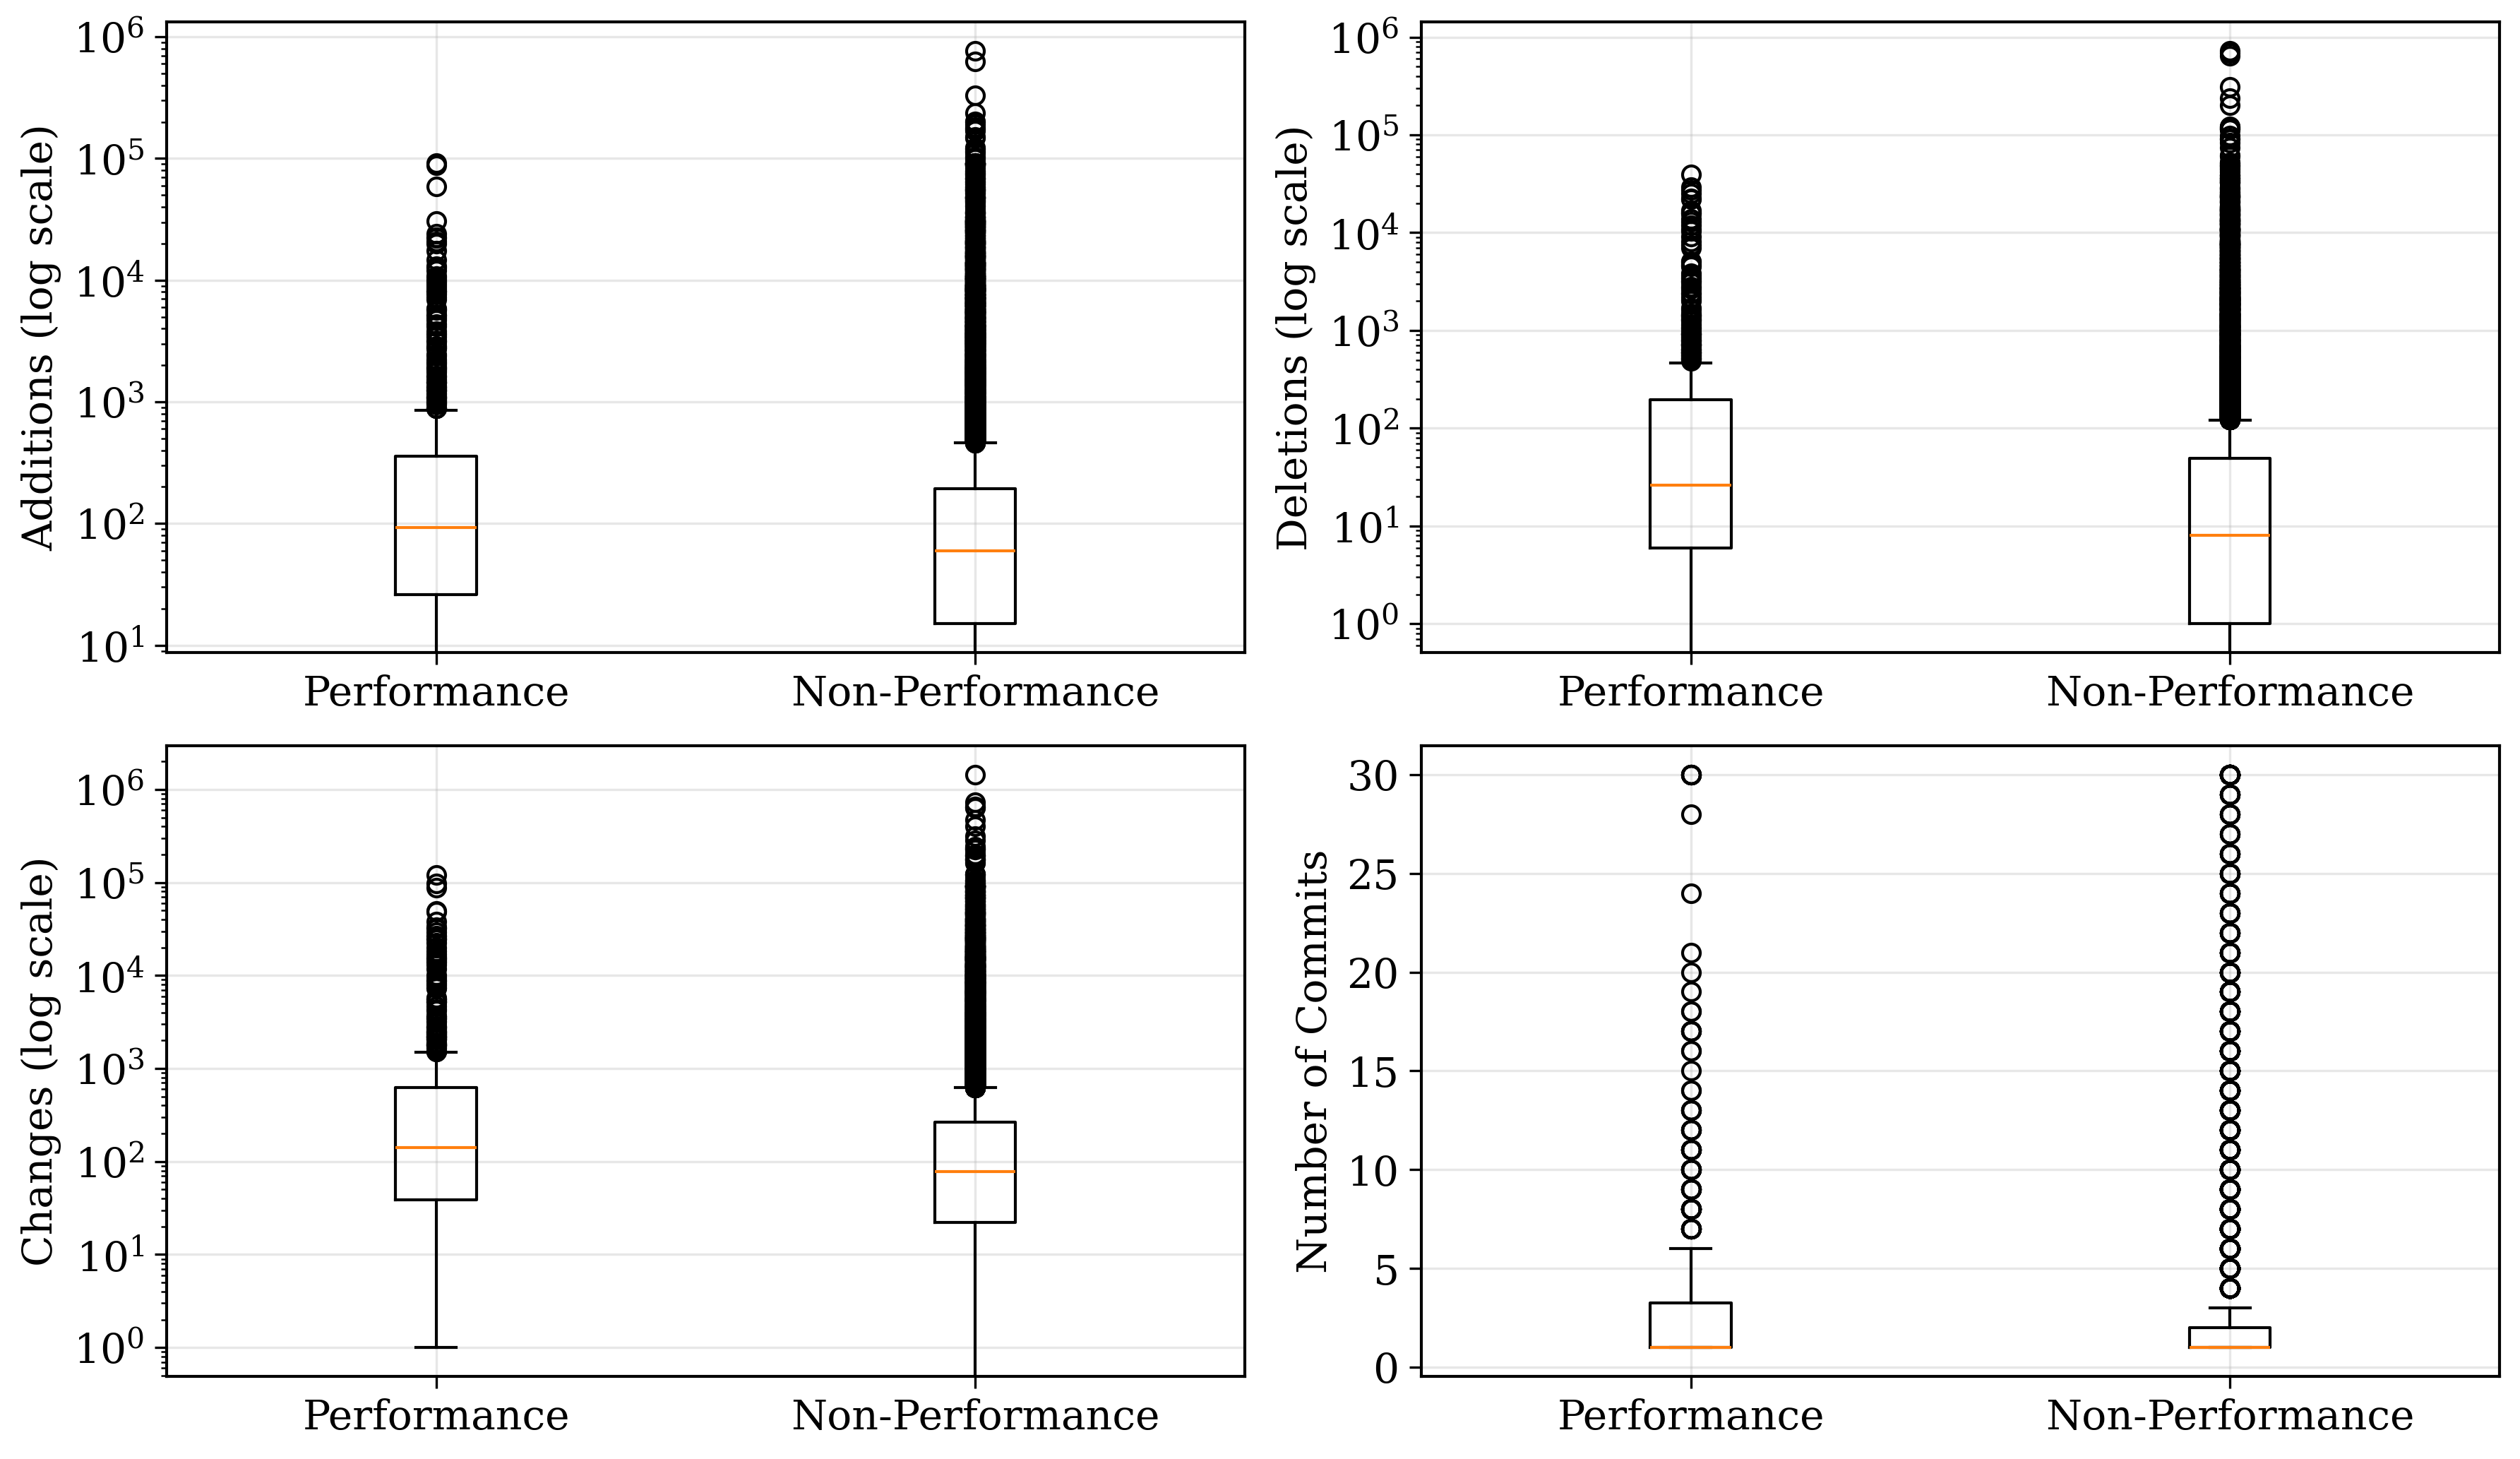

In [35]:
# Create figure with 3 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 7))

# Prepare data for boxplots (Performance first, then Non-Performance)
data_additions = [perf_with_changes['additions'].dropna(), non_perf_with_changes['additions'].dropna()]
data_deletions = [perf_with_changes['deletions'].dropna(), non_perf_with_changes['deletions'].dropna()]
data_changes = [perf_with_changes['changes'].dropna(), non_perf_with_changes['changes'].dropna()]
data_num_commits = [perf_with_changes['num_commits'].dropna(), non_perf_with_changes['num_commits'].dropna()]

# Plot additions
axes[0, 0].boxplot(data_additions, labels=['Performance', 'Non-Performance'])
axes[0, 0].set_ylabel('Additions (log scale)')
axes[0, 0].set_yscale('log')
axes[0, 0].grid(True, alpha=0.3)

# Plot deletions
axes[0, 1].boxplot(data_deletions, labels=['Performance', 'Non-Performance'])
axes[0, 1].set_ylabel('Deletions (log scale)')
axes[0, 1].set_yscale('log')
axes[0, 1].grid(True, alpha=0.3)

# Plot changes
axes[1, 0].boxplot(data_changes, labels=['Performance', 'Non-Performance'])
axes[1, 0].set_ylabel('Changes (log scale)')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.3)

# Plot n_commmits
axes[1, 1].boxplot(data_num_commits, labels=['Performance', 'Non-Performance'])
axes[1, 1].set_ylabel('Number of Commits')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [31]:
perf_with_changes

,id,number,title,body,agent,user_id,user,state,created_at,closed_at,merged_at,repo_id,repo_url,html_url,additions,deletions,changes,num_commits
1,3273233066,1037,feat: implement comprehensive species tracking...,## Summary\nThis PR implements a comprehensive...,Claude_Code,7030001,tphakala,closed,2025-07-29T11:21:11Z,2025-07-29T13:49:45Z,2025-07-29T13:49:45Z,707764474,https://api.github.com/repos/tphakala/birdnet-go,https://github.com/tphakala/birdnet-go/pull/1037,6964.0,1389.0,8353.0,30.0
2,3219880512,10340,feat(backend): Integrate GCS file storage with...,## Summary\n\nThis PR introduces a complete cl...,Claude_Code,76959103,majdyz,closed,2025-07-10T15:52:56Z,2025-07-18T03:20:54Z,2025-07-18T03:20:54Z,614765452,https://api.github.com/repos/Significant-Gravi...,https://github.com/Significant-Gravitas/AutoGP...,92019.0,29232.0,121251.0,28.0
4,3142181649,19,Replace CLI subprocess approach with Claude Co...,## Description\n\nReplace the current CLI subp...,Claude_Code,80381,sugyan,closed,2025-06-13T04:05:15Z,2025-06-13T14:14:33Z,2025-06-13T14:14:33Z,999285986,https://api.github.com/repos/sugyan/claude-cod...,https://github.com/sugyan/claude-code-webui/pu...,199.0,164.0,363.0,5.0
5,3200679276,4304,Implement lazy loading for RegistryInstance to...,👨 \r\n\r\nBefore:\r\n\r\n```\r\njulia> @time P...,Claude_Code,1282691,KristofferC,closed,2025-07-03T21:18:03Z,2025-07-04T08:34:04Z,2025-07-04T08:34:04Z,82341193,https://api.github.com/repos/JuliaLang/Pkg.jl,https://github.com/JuliaLang/Pkg.jl/pull/4304,59.0,29.0,88.0,1.0
7,3250080019,24542,[fix][broker]Fix thread safety issues in Bucke...,### Motivation\r\n\r\nFixes #23190\r\n\r\nBuck...,Claude_Code,10327630,Apurva007,closed,2025-07-21T21:21:39Z,2025-07-22T06:17:01Z,2025-07-22T06:17:01Z,62117812,https://api.github.com/repos/apache/pulsar,https://github.com/apache/pulsar/pull/24542,944.0,24.0,968.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,3080933474,8363,fix(api): Update mocha configuration to use SW...,# feat(api): Update API tests to use SWC inste...,Devin,158243242,devin-ai-integration[bot],closed,2025-05-21T17:17:57Z,2025-05-23T11:06:52Z,2025-05-23T11:06:52Z,400215964,https://api.github.com/repos/novuhq/novu,https://github.com/novuhq/novu/pull/8363,1495.0,719.0,2214.0,30.0
1201,3070322024,21374,perf: add p-limit to _getUsersAvailability to ...,# Add p-limit to _getUsersAvailability\n\n## D...,Devin,158243242,devin-ai-integration[bot],closed,2025-05-17T04:28:35Z,2025-05-17T21:05:45Z,2025-05-17T21:05:45Z,350360184,https://api.github.com/repos/calcom/cal.com,https://github.com/calcom/cal.com/pull/21374,19.0,14.0,33.0,1.0
1211,3240006620,7598,Change default hotstuff-min-timeout for collec...,Collection Node timeout default value is set f...,Devin,158243242,devin-ai-integration[bot],closed,2025-07-17T15:28:36Z,2025-07-17T21:03:27Z,2025-07-17T21:03:27Z,297778512,https://api.github.com/repos/onflow/flow-go,https://github.com/onflow/flow-go/pull/7598,1.0,1.0,2.0,1.0
1212,3240241128,582,Add performance benchmarks requirement to cont...,# Add performance benchmarks requirement to co...,Devin,158243242,devin-ai-integration[bot],closed,2025-07-17T16:47:16Z,2025-07-17T16:50:12Z,2025-07-17T16:50:12Z,955904085,https://api.github.com/repos/antiwork/flexile,https://github.com/antiwork/flexile/pull/582,1.0,0.0,1.0,1.0


## Stat test

In [10]:
def compare_distributions(data1, data2, metric_name):
    # Perform Wilcoxon rank-sum test (Mann-Whitney U test) between Performance and Non-Performance

    statistic, p_value = ranksums(data1, data2)

    print(f"Wilcoxon Rank-Sum Test between Performance and Non-Performance PRs")
    print(f"Metric: {metric_name}")
    print("=" * 50)
    print(f"Test Statistic: {statistic:.4f}")
    print(f"P-value: {p_value:.6f}")

    if p_value < 0.001:
        print("Result: Statistically significant difference (p < 0.001)")
    elif p_value < 0.01:
        print("Result: Statistically significant difference (p < 0.01)")
    elif p_value < 0.05:
        print("Result: Statistically significant difference (p < 0.05)")
    else:
        print("Result: No statistically significant difference (p >= 0.05)")

    # Cliff's Delta effect size
    delta, size = CliffsDelta.cliffsDelta(data1, data2)
    
    print("\nCliff's Delta Effect Size Analysis")
    print("=" * 50)
    print(f"Cliff's Delta: {delta:.4f}")
    print(f"Effect Size: {size}")

In [11]:
compare_distributions(perf_with_changes["additions"], non_perf_with_changes["additions"], "Additions")

Wilcoxon Rank-Sum Test between Performance and Non-Performance PRs
Metric: Additions
Test Statistic: 6.8671
P-value: 0.000000
Result: Statistically significant difference (p < 0.001)

Cliff's Delta Effect Size Analysis
Cliff's Delta: 0.1556
Effect Size: small


In [12]:
compare_distributions(perf_with_changes["deletions"], non_perf_with_changes["deletions"], "Deletions")

Wilcoxon Rank-Sum Test between Performance and Non-Performance PRs
Metric: Deletions
Test Statistic: 11.8293
P-value: 0.000000
Result: Statistically significant difference (p < 0.001)

Cliff's Delta Effect Size Analysis
Cliff's Delta: 0.2680
Effect Size: small


In [13]:
compare_distributions(perf_with_changes["changes"], non_perf_with_changes["changes"], "Changes")

Wilcoxon Rank-Sum Test between Performance and Non-Performance PRs
Metric: Changes
Test Statistic: 7.8566
P-value: 0.000000
Result: Statistically significant difference (p < 0.001)

Cliff's Delta Effect Size Analysis
Cliff's Delta: 0.1780
Effect Size: small


# Categories

In [7]:
category_dfs = {}
for category, topic_list in category_map.items():
    dfs_to_concat = []
    for topic in topic_list:
        if topic in topics:
            df = topics[topic].copy()
            df['topic'] = topic
            df['topic_name'] = topic_map.get(topic, topic)
            df['category'] = category
            dfs_to_concat.append(df)
    
    if dfs_to_concat:
        category_dfs[category] = pd.concat(dfs_to_concat, ignore_index=True)

# Display the categories and their sizes
for category, df in category_dfs.items():
    print(f"{category}: {len(df)} PRs")
print("\nTotal PRs in all categories:", sum(len(df) for df in category_dfs.values()))

Development: 119 PRs
Low-level: 174 PRs
UI: 65 PRs
Caching: 55 PRs
Algorithmic: 56 PRs
Query: 32 PRs
Networking: 54 PRs
Analytics: 28 PRs
Hardware: 27 PRs
AI: 15 PRs

Total PRs in all categories: 625


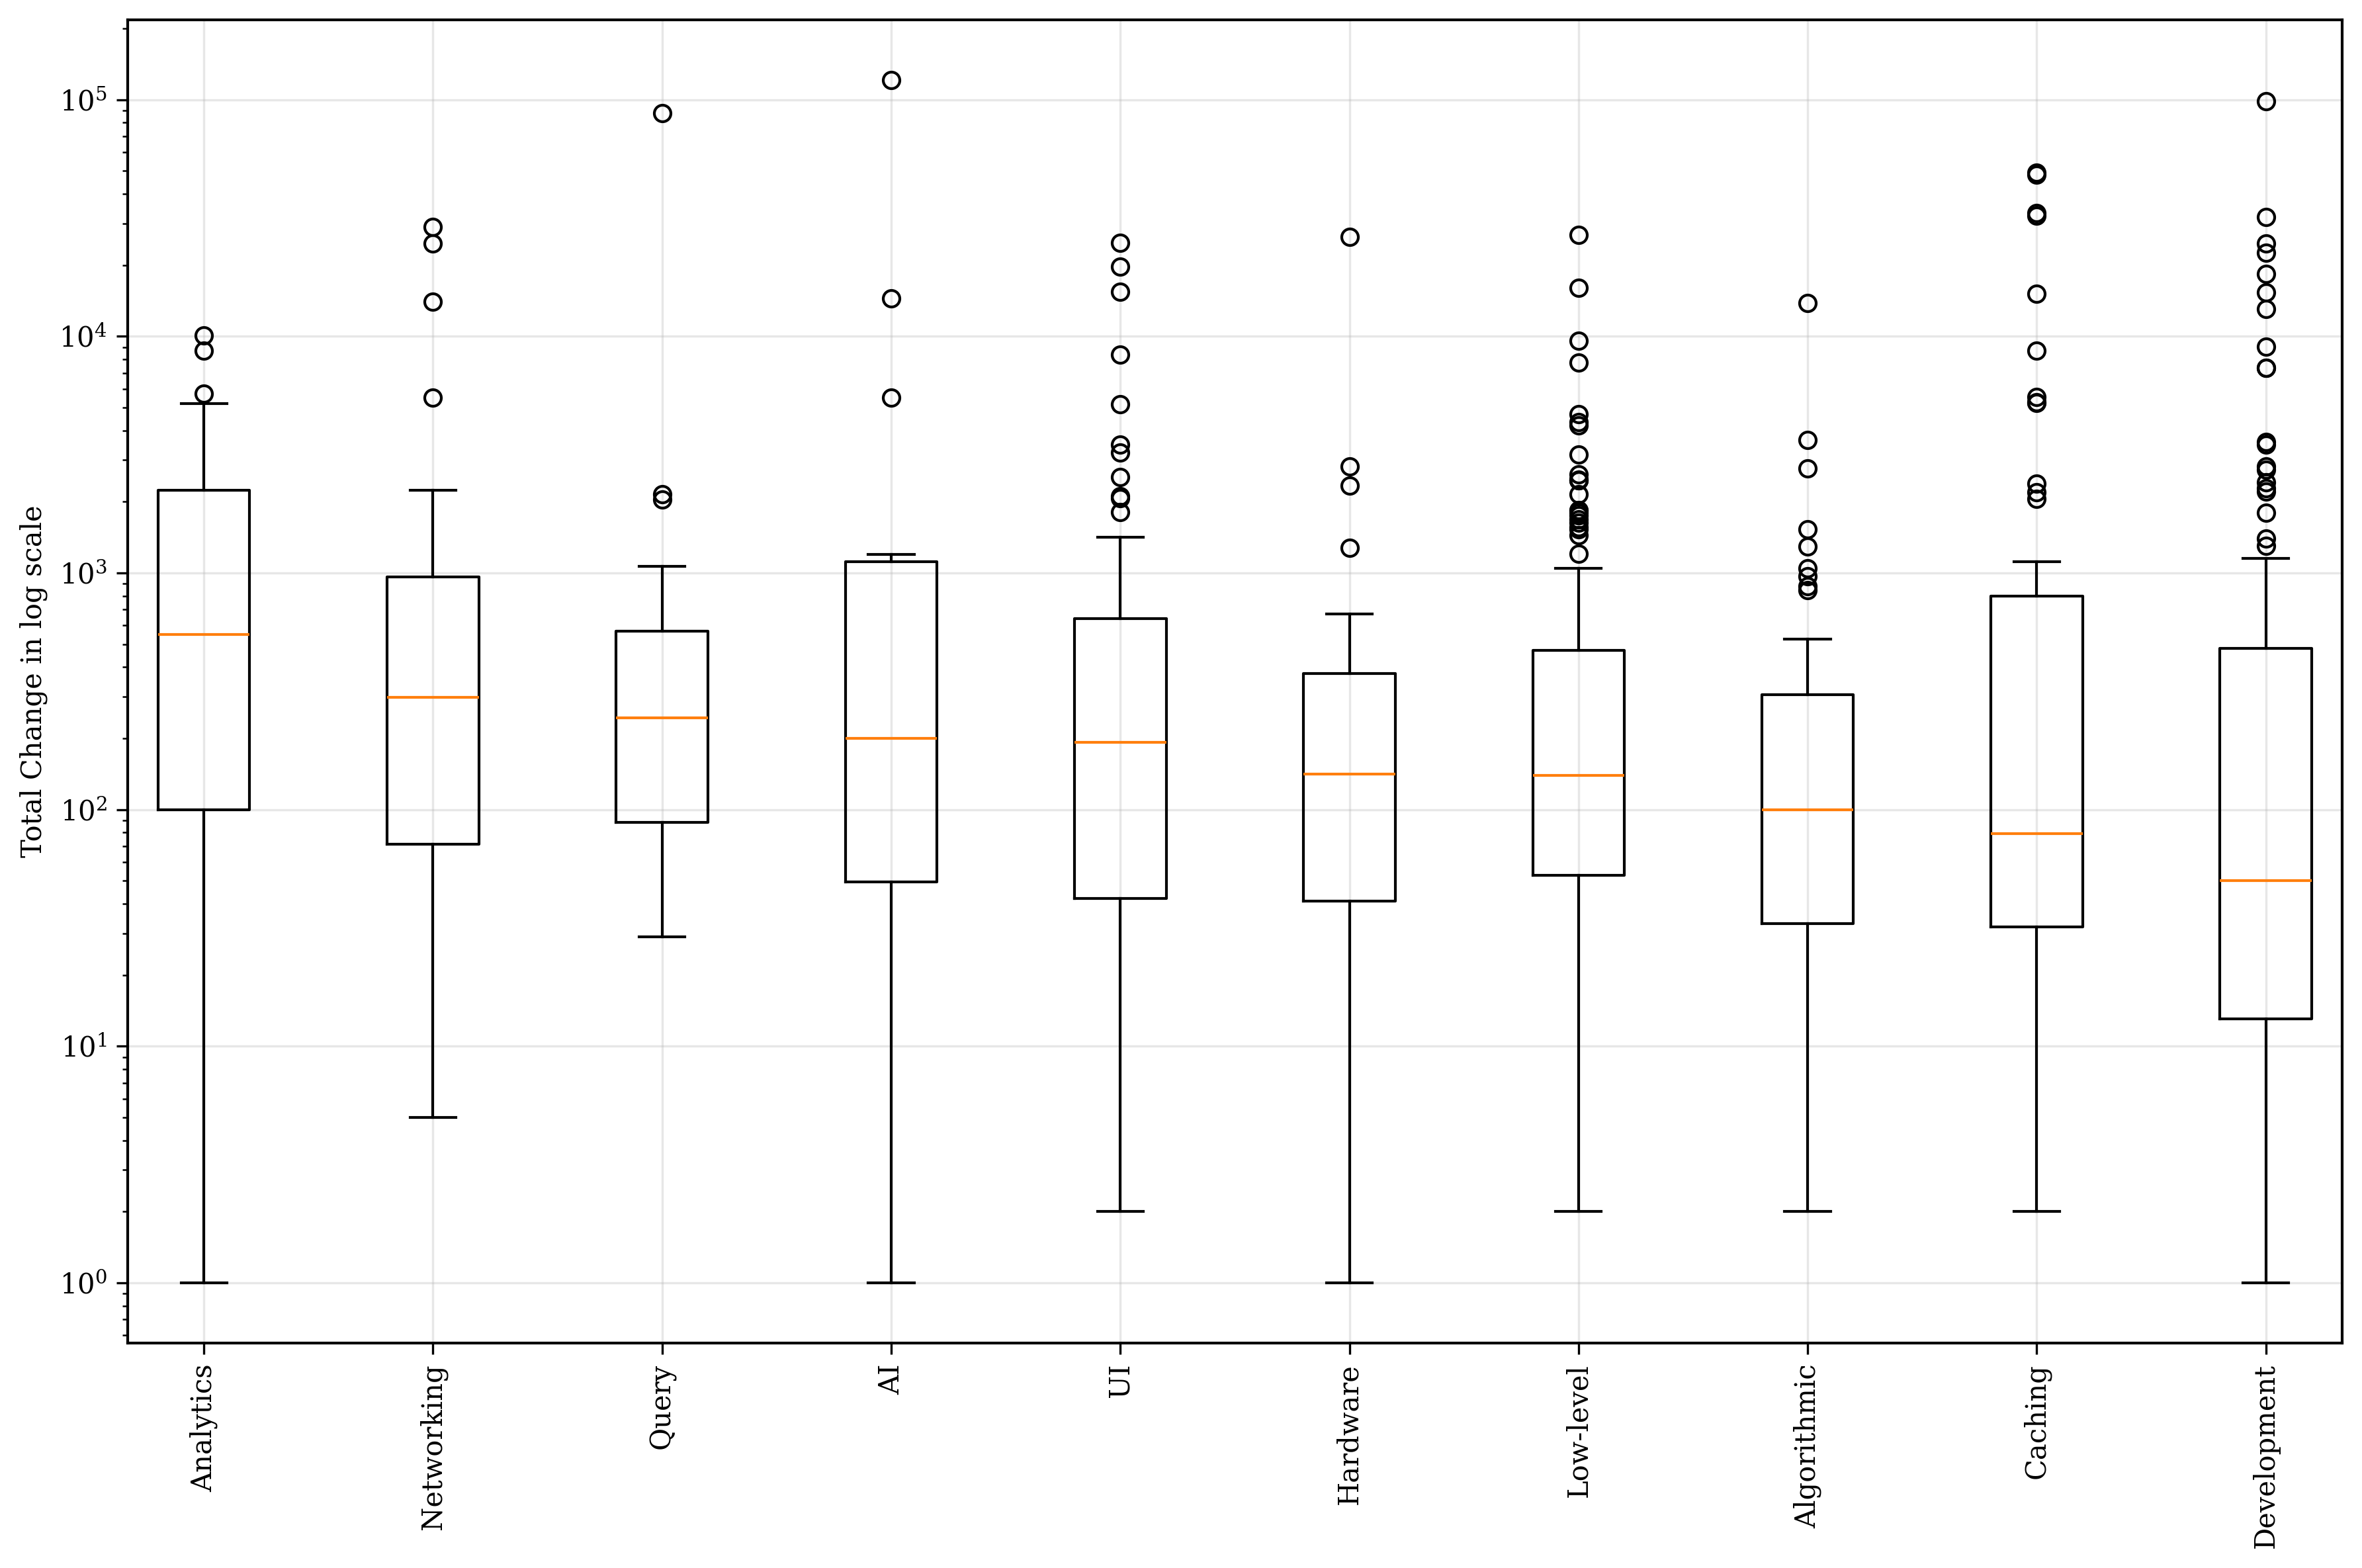

In [8]:
changes = []
median = []
labels = []

for category, df in category_dfs.items():
    df = get_change_details(df)
    changes.append(df["changes"].values)
    median.append(np.median(df["changes"]))
    labels.append(category)
    
stat = pd.DataFrame({
    'Topic': labels,
    'Median': median,
    'Changes': changes
})

stat = stat.sort_values(by='Median', ascending=False)

plt.figure(figsize=(12, 8))
positions = np.arange(len(stat)) * 1.5
plt.boxplot(stat["Changes"], positions=positions, widths=0.6)
plt.xticks(positions, stat["Topic"], rotation=90, ha='center')
plt.yscale('log')
plt.ylabel(f'Total Change in log scale')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


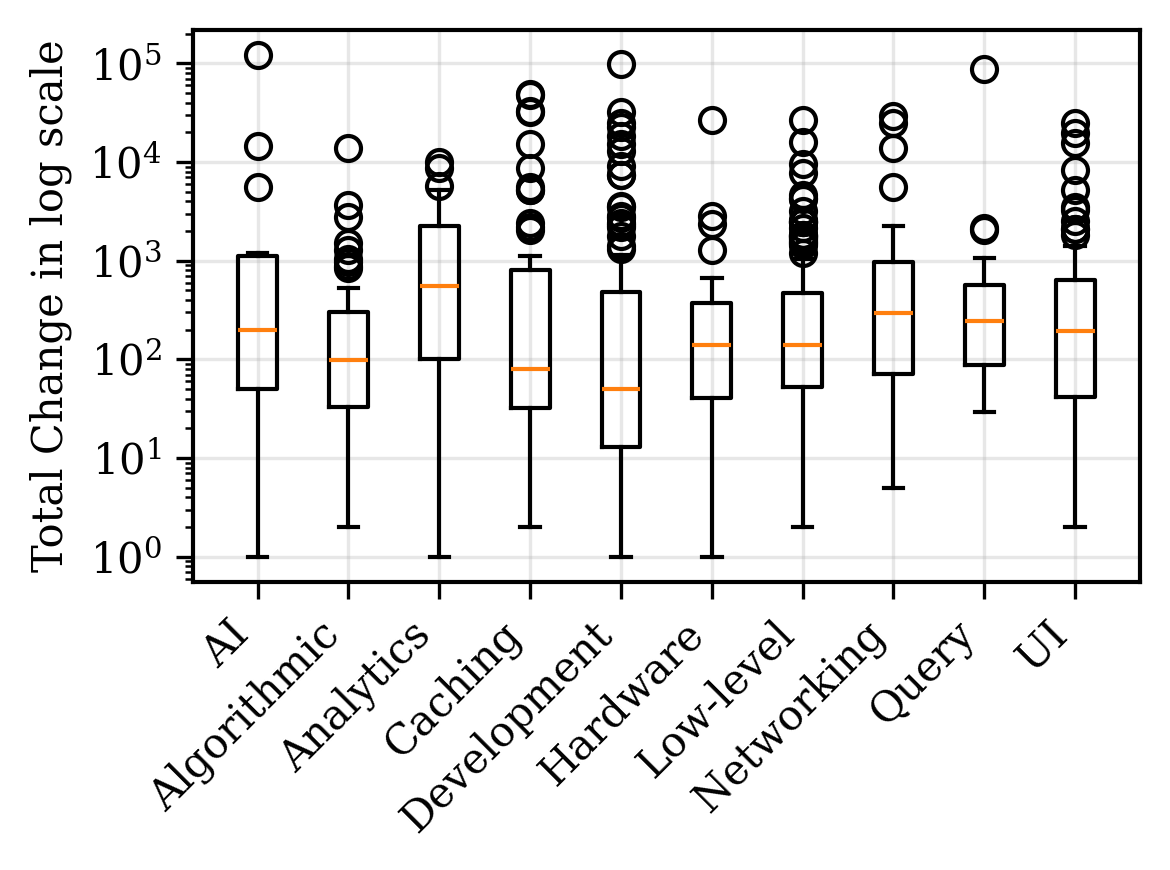

In [13]:
changes = []
median = []
labels = []

for category, df in category_dfs.items():
    df = get_change_details(df)
    changes.append(df["changes"].values)
    median.append(np.median(df["changes"]))
    labels.append(category)
    
stat = pd.DataFrame({
    'Category': labels,
    'Median': median,
    'Changes': changes
})

stat = stat.sort_values(by='Category', ascending=True)

plt.figure(figsize=(4, 3))
positions = np.arange(len(stat)) * 0.7
plt.boxplot(stat["Changes"], positions=positions, widths=0.3)
plt.xticks(positions, stat["Category"], rotation=45, ha='right')
plt.yscale('log')
plt.ylabel(f'Total Change in log scale')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
